For those of you that don't follow basketball, NCAA stands for National Collegiate Athletic Association and this is the body that regulates athletic competition between American colleges. Every March, the NCAA basketball season culminates in 'March Madness', which is a tournament between the best college teams from around the country to crown a national champion.

Kaggle has hosted competitions previously with the aim of trying to create a model that best predicts the outcome of every game in the tournament. This year they have done the same with a financial insentive ($25,000 going to the best prediction!), and this notebook contains my initial attempt to predict the outcomes of games.

If you would like to see the full details of the competition, follow [this](https://www.kaggle.com/c/mens-machine-learning-competition-2018) link.

## This notebook contains the following content:
* [1. Data Sources](#first-bullet)
* [2. Aggregating & Exploring](#second-bullet)
* [3. Testing Different Models](#third-bullet)
* [4. Competition Performance and Improvement Ideas](#fourth-bullet)

## 1. Data Sources <a class="anchor" id="first-bullet"></a>
The competition provided data in various .csv files from previous tournament results and regular season game results to the locations of cities and ranking data from various professional basketball analysts. Let's take a look at some of the data sources: 

In [1]:
# import some data libraries
import numpy as np 
import pandas as pd 

#Import some plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seeds_df = pd.read_csv('data/NCAATourneySeeds.csv') # The data has been downloaded locally
print(seeds_df.head(1))
print(seeds_df.tail(1)) # print the first and last lines

   Season Seed  TeamID
0    1985  W01    1207
      Season  Seed  TeamID
2217    2018  Z16b    1411


This dataframe contains 2218 rows specifying the year of the tournament (Season), the seed of the team (Seed) and the unique team identifier (TeamID). We can see that we have data from 1985 to 2018 (this years tournament). The seed can vary from 1 to 16 for each of the conferences (North, South, East and West), with some play-in games for teams that were deemed equally deserving of a spot (denoted with a Z). 

For our purposes we would like an integer of the seed, so we will extract the characters in indices 1 and 2:

In [3]:
seeds_df['Seed'] = seeds_df['Seed'].apply(lambda x: int(x[1:3])) # lambda function to convert characters 1 & 2 to an integer.
seeds_df.tail(1)

,Season,Seed,TeamID
2217,2018,16,1411


The next data file contains the tournament results from previous years:

In [4]:
tourney_results_df = pd.read_csv('data/NCAATourneyCompactResults.csv')
print(tourney_results_df.head(1))
print(tourney_results_df.tail(1))

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
      Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
2116    2017     154     1314      71     1211      65    N      0


This dataframe contains:
* Season - Year that the tournament falls in.
* DayNum - Day number of the specific game. 
* WTeamID - TeamID of the winning team.
* LTeamID - TeamID of the losing team.
* WScore/LScore - Total points of the winning/losing teams.
* WLoc - H if the winning team was at home, A if the winning team was away from home, N for neutral.
* NumOT - Specifies the number of overtime periods if the game was tied at the end of regulation.

We again have data beginning from 1985, but this time the data stops at 2017. This is because the 2018 results are the ones that we are trying to predict. 

The next data file contains the regular season results:

In [5]:
season_results_df = pd.read_csv('data/RegularSeasonCompactResults.csv')
print(season_results_df.head(1))
print(season_results_df.tail(1))

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985      20     1228      81     1328      64    N      0
        Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
156088    2018     132     1335      68     1217      65    N      0


The columns in this dataframe are identical to the previous dataframe. This time we have results up to 2018 because at the time of writing the 2018 regular season is finished and we need these results to compare the 2 teams in a matchup and generate a prediction.

The next data file contains more detailed information on regular season games:

In [6]:
season_teambox_df = pd.read_csv('data/RegularSeasonDetailedResults.csv')
print(season_teambox_df.head(1))
print(season_teambox_df.tail(1))

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   

  ...   LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0 ...      10    16    22   10   22     8   18     9     2   20  

[1 rows x 34 columns]
       Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  \
82040    2018     132     1335      68     1217      65    N      0    24   

       WFGA ...   LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
82040    52 ...      18    12    12    5   29     6    8     2     2   17  

[1 rows x 34 columns]


This dataframe contains the same columns as the compact results file but with additional statistics for each team such as the number of field goals attempted, number of defensive or offensive rebounds and so on.If you are unfamiliar with Basketball statistics and would like to understand what the abbreviations mean then they can be found [here](https://en.wikipedia.org/wiki/Basketball_statistics), a prefix of L or W indicate that statistic is for the Losing or Winning team respectively. 

We can use these individual game statistics to build up a representation for a teams play-style and performance over the season, and use the difference between these statistics for 2 teams in a matchup as a feature to help to describe the outcome (winning or losing).

Unfortunately the league only began officially tracking this detailed data from 2003 onwards, but this still gives us 14 seasons of detailed data to train with.

## 2. Aggregating & Exploring <a class="anchor" id="second-bullet"></a>
### Seed Difference
It is intuitive that the seed of a team would be very important when predicting a win or a loss. You would expect a team with a seed closer to 1 (the top seed) to be more likely to win than a team with a seed closer to 16 (the bottom seed). For each tournament match that has been played in the past, we would like to look at the difference in seed between the team that won and the team that lost.

In [7]:
# because of the different column names between the data sources we copy our seeds_df
# and rename the columns to be consistent with the tourney_results_df
win_seeds_df = seeds_df.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
lose_seeds_df =  seeds_df.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})

In [8]:
# then we can merge the data frames in turn to add 2 new columns
# the winning team seed and the losing team seed
tourney_data = tourney_results_df.merge(right=win_seeds_df, how='left', on=['Season', 'WTeamID']) #first merge
tourney_data = tourney_data.merge(right=lose_seeds_df, how='left', on=['Season', 'LTeamID']) #seconds merge
# since the tournaments are always in a neutral location
# we can drop the WLoc column
tourney_data.drop(['WLoc'], axis=1, inplace=True)

In [9]:
# create a new column, SeedDiff, that subtracts the losers seed from the winners seed
tourney_data['SeedDiff'] = tourney_data['WSeed'] - tourney_data['LSeed']
# remove unneeded columns for now
tourney_data.drop(['WSeed','LSeed','DayNum','WScore','LScore','NumOT'], axis=1, inplace=True)
tourney_data.head()

,Season,WTeamID,LTeamID,SeedDiff
0,1985,1116,1234,1
1,1985,1120,1345,5
2,1985,1207,1250,-15
3,1985,1229,1425,1
4,1985,1242,1325,-11


Let's take a look at the distribution of seed differences.

Text(0.5,1,'Count of occurences of Tournament SeedDiff since 1985')

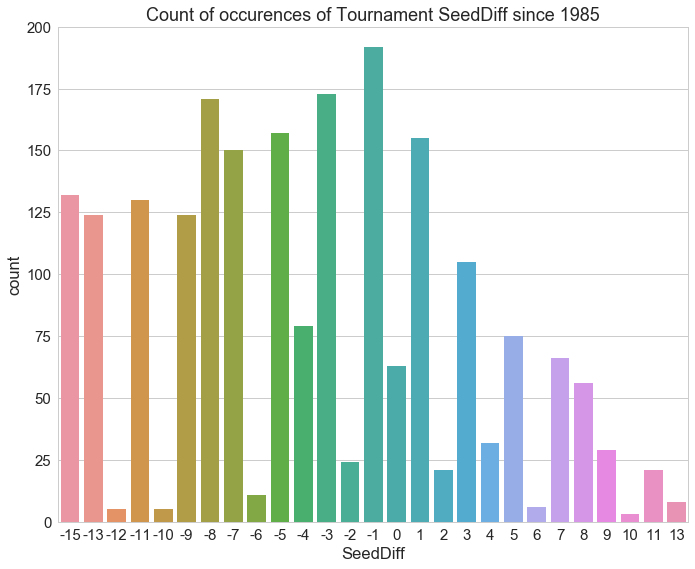

In [10]:
sns.set(font_scale=1.5, style='whitegrid')
plt.figure(figsize=(10,8))
sns.countplot(tourney_data['SeedDiff'])
plt.tight_layout()
plt.ylim((0,200))
plt.title('Count of occurences of Tournament SeedDiff since 1985')

Text(0.5,1,'Box & whisker plot of Tournament SeedDiff since 1985')

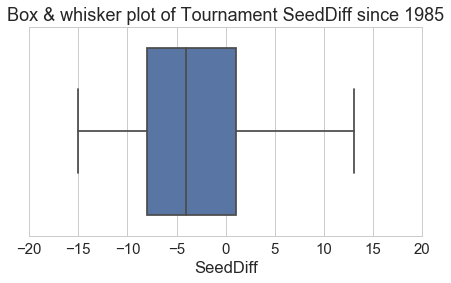

In [11]:
sns.boxplot(tourney_data['SeedDiff'])
plt.tight_layout()
plt.xlim((-20,20))
plt.title('Box & whisker plot of Tournament SeedDiff since 1985')

From the above plots we can see that it is more common to have a negative seed difference (where the winning team has a lower seed integer than the losing team) which agrees with our initial intuition. The median SeedDiff is -4, minimum SeedDiff is -15 (1 seed beating 16 seed happens in the first round every year) and the maximum is 13 (so far, no 16 seed has beaten a 1 seed as this would appear as a SeedDiff of 15). 
Let's calculate the percentage of games won by the lower seed integer:

In [12]:
negative_seed_diff = len(tourney_data[tourney_data['SeedDiff']<0])
total_games = len(tourney_data)
print('If we were to always predict the team with the best seed wins, we would expect an accuracy of ' + str(round(100*(float(negative_seed_diff)/total_games),2)) + '%')

If we were to always predict the team with the best seed wins, we would expect an accuracy of 69.77%


69.8% means that the feature SeedDiff is very descriptive of the outcome, however we would like to do better than this. 

### Creating additional features
Now we want to calculate some season statistics for each team based on the regular season. Unfortunately these advanced stats require data that isn't present in information before 2003, which means we lose a lot of our training datapoints. For more detail on the statistics below see [here](https://www.basketball-reference.com/about/glossary.html).

#### The stats we will be looking at are:
* **Possessions** - A measure of the number of posessions that each team has during a game. This stat is used to calculate many other ratings. There are 2 formulas that we can use. 
  * Basic Possession =  0.96*[(Field Goal Attempts)+(Turnovers)+0.44*(Free Throw Attempts)-(Offensive Rebounds)]
  * Specific Posession = 0.5*((Field Goal Attempts + 0.4*Free Throw Attempts – 1.07*(Offensive Rebounds/(Offensive Rebounds + Opponent Defensive Rebounds))*(Field Goal Attempts – FG) + Turnovers) + (Opponent Field Goal Attempts + 0.4*(Opponent Free Throw Attempts) – 1.07*(Opponent Offensive Rebounds)/(Opponent Offensive Rebounds + Defensive Rebounds))*(Opponent Field Goal Attempts – Opponent FG) + Opponent Turnovers))
 
* **Pace** - A measure of a teams possessions per 40 minutes. 
  * Pace = [200/(Team Minutes)]*(Possession + Opponent Possession)/2
* **Offensive Efficiency** - A measure of the points scored per 100 possessions.
  * OffEff = 100*(Points Scored)/(Possessions)
* **Defensive Efficiency** - A measure of the points allowed per 100 possessions.
  * DefEff = 100*(Points Scored)/(Possessions)
* **Assist Ratio** - A measure of how many posessions end in an assist.
  * AssRat = (Assists)*100)/ [(Field Goal Attempts)+(Free Throw Attempts*0.44)+(Assists)+(Turnovers)]
* **Defensive & Offensive Rebound %** - A measure of defensive/offensive rebounds made out of all possible defensive/offensive rebounds.
  * DefReb = (Team Defensive Rebounds)/[(Team Defensive Rebounds)+Opponent's Offensive Rebounds)]
  * OffReb = (Team Offensive Rebounds)/[(Team Offensive Rebounds)+Opponent's Defensive Rebounds)]
* **Effective FG %** - A measure of a teams shooting. Can be applied to both offense and defense.
  * eFG = (Field Goals Made) + 0.5*3P Field Goals Made))/(Field Goal Attempts) 
* **Turnover Rate** - A measure of how well a team takes care of the ball.
  * TurnRate = Turnovers/(Field Goal Attempts + 0.44*Free Throw Attempts + Turnovers)
* **Free Throw Rate** - A measure of how many free throws a team shoots per field goal.
  * FreeThrowRate = Free Throws Attempted/Field Goals Attempted
  
Phew, that's a lot of stats! We will use our seeds dataframe as a base, so that we only calculate stats for teams that were in the tournament. We will also drop all rows before 2003 because the detailed stats aren't available before this date.

In [13]:
# remove seasons before 2003
seeds_df = seeds_df[seeds_df['Season'] >= 2003].reset_index(drop=True)

In [14]:
# Function to count number of wins and losses for every team during the regular season
# These are used to calculate weighted averages of other statistics over wins/losses
def count_wins(row):
    
    year = row['Season']
    teamID = row['TeamID']
    
    #create an intermediate dataframe that has all of the wins in this season for this team
    temp_df = season_teambox_df[(season_teambox_df['Season'] == year) & (season_teambox_df['WTeamID'] == teamID)]
    row['Wins'] = len(temp_df)
    
    #create an intermediate dataframe that has all of the losses in this season for this team
    temp_df = season_teambox_df[(season_teambox_df['Season'] == year) & (season_teambox_df['LTeamID'] == teamID)]
    row['Losses'] = len(temp_df)

    return row

#apply the function to every row in the seeds dataframe
seeds_df = seeds_df.apply(count_wins, axis=1)
seeds_df.head(1)

,Season,Seed,TeamID,Wins,Losses
0,2003,1,1328,24,6


In [15]:
# The best way to calculate the other stats is to calculate them per game
# Then we can use a function like the one above to grab the average for when the team wins
# and the average for when a team loses. Then do the weighted average to calculate the total.

# First we need the number of minutes in each game
# A game is 40 minutes, if tied after 40 minutes there are 5 minute OT periods until there is a winner
season_teambox_df['Mins'] = 40 + (5* season_teambox_df['NumOT'])

In [16]:
# Now we will calculate the advanced posession
season_teambox_df['WPoss'] = (season_teambox_df['WFGA'].astype(float)+0.4*season_teambox_df['WFTA'].astype(float)-1.07*(season_teambox_df['WOR'].astype(float)/(season_teambox_df['WOR'].astype(float) + season_teambox_df['LDR'].astype(float)))*(season_teambox_df['WFGA'].astype(float)-season_teambox_df['WFGM'].astype(float)) + season_teambox_df['WTO'].astype(float))
season_teambox_df['LPoss'] = (season_teambox_df['LFGA'].astype(float)+0.4*season_teambox_df['LFTA'].astype(float)-1.07*(season_teambox_df['LOR'].astype(float)/(season_teambox_df['LOR'].astype(float) + season_teambox_df['WDR'].astype(float)))*(season_teambox_df['LFGA'].astype(float)-season_teambox_df['LFGM'].astype(float)) + season_teambox_df['LTO'].astype(float))
season_teambox_df['AvgPoss'] = (season_teambox_df['WPoss'] + season_teambox_df['LPoss'])/2

In [17]:
#Now we will calculate the pace metric
season_teambox_df['Pace'] = (200.0/(season_teambox_df['Mins'] * 5)) * 0.5*(season_teambox_df['WPoss']+season_teambox_df['LPoss'])

In [18]:
#Offensive and Defensive efficiency for both teams
season_teambox_df['WOffEff'] = 100 * (season_teambox_df['WScore']/season_teambox_df['AvgPoss'])
season_teambox_df['LOffEff'] = 100 * (season_teambox_df['LScore']/season_teambox_df['AvgPoss'])
season_teambox_df['WDefEff'] = season_teambox_df['LOffEff']
season_teambox_df['LDefEff'] = season_teambox_df['WOffEff']

In [19]:
# Assist Ratio
season_teambox_df['WAssistRatio'] = 100 * season_teambox_df['WAst'] / ((season_teambox_df['WFGA'])+(season_teambox_df['WFTA'].astype(float)*0.44)+(season_teambox_df['WAst'])+(season_teambox_df['WTO']))
season_teambox_df['LAssistRatio'] = 100 * season_teambox_df['LAst'] / ((season_teambox_df['LFGA'])+(season_teambox_df['LFTA'].astype(float)*0.44)+(season_teambox_df['LAst'])+(season_teambox_df['LTO']))

In [20]:
# Def and Off Reb ratios
season_teambox_df['WDefReb'] = season_teambox_df['WDR'].astype(float)/(season_teambox_df['WDR']+season_teambox_df['LOR'])
season_teambox_df['WOffReb'] = season_teambox_df['WOR'].astype(float)/(season_teambox_df['WOR']+season_teambox_df['LDR'])
season_teambox_df['LDefReb'] = 1 - season_teambox_df['WOffReb']
season_teambox_df['LOffReb'] = 1 - season_teambox_df['WDefReb']

In [21]:
# Defensive and offensive eFG ratio for both teams
season_teambox_df['WOeFG'] = (0.5*season_teambox_df['WFGM3'].astype(float) + season_teambox_df['WFGM'])/(season_teambox_df['WFGA'])
season_teambox_df['LOeFG'] = (0.5*season_teambox_df['LFGM3'].astype(float) + season_teambox_df['LFGM'])/(season_teambox_df['LFGA'])
season_teambox_df['WDeFG'] = season_teambox_df['LOeFG']
season_teambox_df['LDeFG'] = season_teambox_df['WOeFG']

In [22]:
# Turnover Rate
season_teambox_df['WTORate'] = season_teambox_df['WTO']/(season_teambox_df['WFGA'] + 0.44*season_teambox_df['WFTA'].astype(float) + season_teambox_df['WTO'])
season_teambox_df['LTORate'] = season_teambox_df['LTO']/(season_teambox_df['LFGA'] + 0.44*season_teambox_df['LFTA'].astype(float) + season_teambox_df['LTO'])

In [23]:
# Free Throw Rate
season_teambox_df['WFTRate'] = season_teambox_df['WFTA'].astype(float)/season_teambox_df['WFGA']
season_teambox_df['LFTRate'] = season_teambox_df['LFTA'].astype(float)/season_teambox_df['LFGA']

#### We have now calculated the stats that we want on a per game basis. The next step is to calculate a season average for each team in seeds_df, which will be:
((NumWins * AverageWhenWinning) + (NumLosses * AverageWhenLosing)) / (NumWins + NumLosses)

In [24]:
def calc_season_averages(row):
    year = row['Season']
    teamID = row['TeamID']
    n_wins = row['Wins']
    n_loss = row['Losses']
    
    
    # for loop going through each stat and calculating the season average
    for stat in ['OffEff','DefEff','AssistRatio','DefReb','OffReb','OeFG','DeFG','TORate','FTRate']:
        if n_loss > 0: # need to account for situation where teams have no losses
            # don't need to account for teams with no wins because we can safely assume they wouldn't make it to the tournament
            win_average = season_teambox_df.loc[(season_teambox_df['Season'] == year) & (season_teambox_df['WTeamID'] == teamID)]['W'+ stat].mean()
            loss_average = season_teambox_df.loc[(season_teambox_df['Season'] == year) & (season_teambox_df['LTeamID'] == teamID)]['L'+ stat].mean()
            row[stat] = ((n_wins * win_average) + (n_loss * loss_average))/(n_wins+n_loss)
        else:
            average = season_teambox_df.loc[(season_teambox_df['Season'] == year) & (season_teambox_df['WTeamID'] == teamID)]['W'+ stat].mean()
            row[stat] = average
    
    return row

In [25]:
# add new columns to the seeds dataframe which contain that teams stat averages for that season
seeds_df = seeds_df.apply(calc_season_averages,axis=1)
seeds_df.head()

,Season,Seed,TeamID,Wins,Losses,OffEff,DefEff,AssistRatio,DefReb,OffReb,OeFG,DeFG,TORate,FTRate
0,2003.0,1.0,1328.0,24.0,6.0,110.261491,93.706513,15.360582,0.709854,0.347284,0.512124,0.448150,0.155078,0.332030
1,2003.0,2.0,1448.0,24.0,5.0,114.430151,98.950890,14.767892,0.687237,0.429724,0.511972,0.463124,0.178941,0.472499
2,2003.0,3.0,1393.0,24.0,5.0,112.094794,98.159874,14.605903,0.630790,0.385242,0.515151,0.445717,0.160408,0.393873
3,2003.0,4.0,1257.0,24.0,6.0,114.208872,95.335218,16.223909,0.664037,0.356053,0.528861,0.450485,0.156505,0.418922
4,2003.0,5.0,1280.0,21.0,9.0,105.989995,91.456897,15.403314,0.695785,0.383446,0.521359,0.463462,0.197467,0.323860


#### Now we have a table of each seeded teams season stats since 2003. We can use these to help compare the 2 teams in any particular matchup.

In [26]:
# Remove data from before 2003 from the touney_data dataframe and reset the index
tourney_data = tourney_data[tourney_data['Season'] >= 2003].reset_index(drop=True)

In [27]:
def get_matchup_data(row):
    year = row['Season']
    team1 = row['WTeamID']
    team2 = row['LTeamID']
    
    #for each stat that we have averages for
    for stat in ['OffEff','DefEff','AssistRatio','DefReb','OffReb','OeFG','DeFG','TORate','FTRate']:
        
        #create a new column that is the difference between the average of the stat for the 2 teams in a match
        row[stat + 'Diff'] = seeds_df.loc[(seeds_df['Season'] == year) & (seeds_df['TeamID'] == team1)][stat].values[0] - seeds_df.loc[(seeds_df['Season'] == year) & (seeds_df['TeamID'] == team2)][stat].values[0]
        
    return row

tourney_data = tourney_data.apply(get_matchup_data, axis=1)
tourney_data.head()

,Season,WTeamID,LTeamID,SeedDiff,OffEffDiff,DefEffDiff,AssistRatioDiff,DefRebDiff,OffRebDiff,OeFGDiff,DeFGDiff,TORateDiff,FTRateDiff
0,2003.0,1421.0,1411.0,0.0,-0.796114,11.509018,-0.884582,-0.056104,-0.012949,-0.013235,0.024351,0.012414,-0.152277
1,2003.0,1112.0,1436.0,-15.0,8.733813,-3.451230,0.917347,-0.052338,0.014010,0.022900,-0.020695,-0.019188,0.031691
2,2003.0,1113.0,1272.0,3.0,3.050599,5.663538,-0.571396,0.000045,0.031277,0.018997,0.039381,0.006264,0.071937
3,2003.0,1141.0,1166.0,5.0,-4.263461,8.642600,-1.343562,-0.019458,0.019944,0.005381,0.026953,0.055825,0.127689
4,2003.0,1143.0,1301.0,-1.0,-2.421135,-2.595967,0.370166,0.010425,0.013497,-0.010092,-0.001493,-0.012174,-0.039185


We now have a number of features that could help to describe the outcome of the game. Let's take a quick look at the distributions of the stat differences.

Text(0.5,1.02,'Distribution of Tournament stat differences since 2003.')

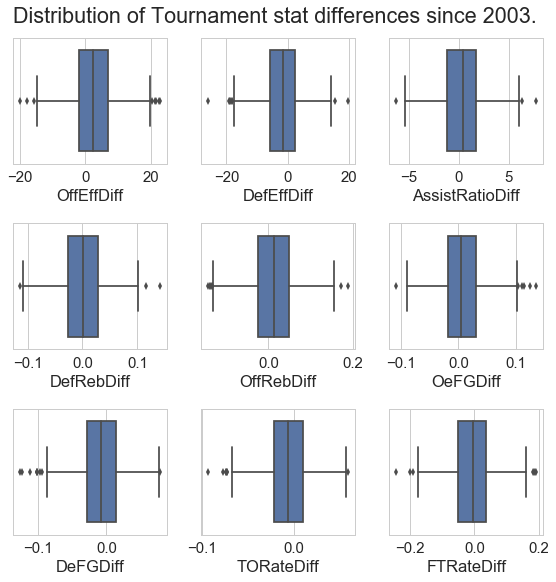

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(8)
fig.set_figwidth(8)

for idx, stat in enumerate(['OffEff','DefEff','AssistRatio','DefReb','OffReb','OeFG','DeFG','TORate','FTRate']):
    
    sns.boxplot(tourney_data[stat + 'Diff'], ax=axes[int(idx/3), idx % 3])
    
plt.tight_layout()
plt.suptitle('Distribution of Tournament stat differences since 2003.', y=1.02)

**Some notes:**
* Teams with higher offensive efficiency and lower defensive efficiency (lower defensive efficiency actually means they allowed fewer points to be scored) tended to win more.
* Teams that recorded more assists tended to win more.
* Defensive rebound rate difference is fairly evenly distributed above and below zero.
* Teams that recorded more offensive rebounds tended to win more.
* Teams that recorded fewer turnovers tended to win more.
* All of the distributions for detailed stat differences are centred closer to zero than the distribution for SeedDiff.


If we were to use the data rows as-is for our training set we would only have examples where the outcome is a win (the TeamID wouldn't be used as a feature). For all of the examples that we have, if we were to multiply all of the difference features by minus one then we would essentially be swapping the outcome to a loss.

In [29]:
win_data = tourney_data.drop(['Season','WTeamID','LTeamID'], axis=1)
loss_data = -1 * win_data
# specify original format data to have a result of 1 i.e. a win
# give the negative version a result of 0 i.e. a loss
win_data['Result'] = 1 
loss_data['Result'] = 0
train_data = pd.concat([win_data,loss_data])
train_data.head()

,SeedDiff,OffEffDiff,DefEffDiff,AssistRatioDiff,DefRebDiff,OffRebDiff,OeFGDiff,DeFGDiff,TORateDiff,FTRateDiff,Result
0,0.0,-0.796114,11.509018,-0.884582,-0.056104,-0.012949,-0.013235,0.024351,0.012414,-0.152277,1
1,-15.0,8.733813,-3.451230,0.917347,-0.052338,0.014010,0.022900,-0.020695,-0.019188,0.031691,1
2,3.0,3.050599,5.663538,-0.571396,0.000045,0.031277,0.018997,0.039381,0.006264,0.071937,1
3,5.0,-4.263461,8.642600,-1.343562,-0.019458,0.019944,0.005381,0.026953,0.055825,0.127689,1
4,-1.0,-2.421135,-2.595967,0.370166,0.010425,0.013497,-0.010092,-0.001493,-0.012174,-0.039185,1


#### Let's check the correlation between the different features and the 'Result' column

Text(0.5,1,'Correlation of feature matrix and result column')

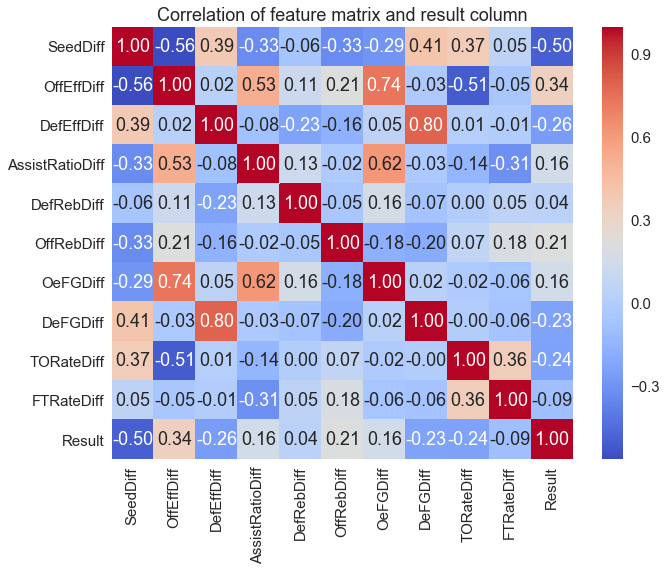

In [30]:
corr = train_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.tight_layout()
plt.title('Correlation of feature matrix and result column')

### Some notes on the above correlations:
* A number of the features are fairly highly correlated. OffEff, DefEff, AssistRatio, OffReb, both eFG and TORate all have correlations with the Seed. This is inescapable as teams with better stats are likely to have a better seed.
* The highest correlations are between OffEff and OeFG (makes sense, if you shoot well you are likely to have a high offensive efficiency), DefEff and DeFG (if your opponents generally shoot badly then they will not be scoring many points),  AssistRatio and OffEff/OeFG (lots of team plays ending in an assist are generally high % shots). 
* Although SeedDiff still has the highest correlation with the Result, we now have a number of new features that also have  reasonable correlation with the Result. This might help to differentiate 2 matchups that have the same SeedDiff.
* From the look of the correlation magnitudes, we can probably drop the FTRateDiff and DefRebRateDiff

In [31]:
train_data.drop(['FTRateDiff','DefRebDiff'], axis=1, inplace=True)

## 3. Testing Different Models <a class="anchor" id="third-bullet"></a>

Now that we have a feature matrix, let's split the data into a training set and a test set. We don't need to worry about majority class bias because we have the same number of wins and losses in our dataset.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#split into training and testing sets, 20% of data in test set, shuffling the data because it is currently all wins followed by all losses.
X_train, X_test, Y_train, Y_test = train_test_split(train_data.drop('Result', axis=1), train_data['Result'], 
                                                    test_size=0.2, random_state=20, shuffle=True)
# create a scaler object
scaler = StandardScaler()

#fit the scaler to the training set and then transform the test set
#we don't fit the scaler to the whole dataset because this can cause leakage
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

.Next we can import some different models to try initial fits on the data

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

# create instances with default parameters for the moment
# expect some overfitting to the training set
logreg_model = LogisticRegression()
dtree_model = DecisionTreeClassifier()
sv_model = SVC(probability=True)

# store models in a list so we can iterate
models = [logreg_model, dtree_model, sv_model]

# iterate through models, performing cross-validation with the training data
# report the average performance and deviation of each model
# we use a cross-entropy/log-loss scoring model
for model in models:
    cv_scores = cross_validate(model, X_train, y=Y_train, scoring='neg_log_loss', cv=5, return_train_score=True)
    print('The average training score for model %s is %.3f with a deviation of %.4f' % (str(model).split('(')[0], cv_scores['train_score'].mean(), cv_scores['train_score'].std()))
    print('The average test score for model %s is %.3f with a deviation of %.4f' % (str(model).split('(')[0], cv_scores['test_score'].mean(), cv_scores['test_score'].std()))

The average training score for model LogisticRegression is -0.530 with a deviation of 0.0047
The average test score for model LogisticRegression is -0.535 with a deviation of 0.0185
The average training score for model DecisionTreeClassifier is -0.000 with a deviation of 0.0000
The average test score for model DecisionTreeClassifier is -12.527 with a deviation of 1.0381
The average training score for model SVC is -0.526 with a deviation of 0.0056
The average test score for model SVC is -0.574 with a deviation of 0.0213


It can be seen that the decision tree classifier has the best training scores (zero loss) and it achieves this on every fold of cross-validation, however the score on the test folds is terrible. This is because the tree is not limited in any way and so it continues to grow until it fits the training sets perfectly (overfitting).

Both the logistic and support vector classifiers achieve reasonable scores and deviations, with the logistic model performing best on the test folds. Both models might improve significantly with hyperparameter tuning. For this notebook I have chosen to take the logistic regression model forward.

### Hyperparameter tuning
The main hyperparameter for a logistic regression model is the regularization strength. The most common penalty, L2 penalty, effectively causes a shrinkage of the logistic regression coefficients between each gradient descent update to prevent them from becoming too large. Large coefficients tend to indicate overfitting to training data.

To choose the best value of the L2 penalty, we can define a space of values to search over and use cross-validation to fit a model with each L2 value, keeping track of the training and validation scores as we go. After this, we can choose the L2 penalty that gave the best validation score. **Note**: The value of C is **inversely proportional** to the regularization strength i.e. high C value provides less of a regularization effect.

In [34]:
# create a logarithmically spaced set of penalty values to try
L2_values =np.logspace(-4, 1, num=50, base=10.0)
train_scores = []
val_scores = []

#loop through the penalty values, storing the scores in a list
for C in L2_values:
    logreg_model = LogisticRegression(C=C)
    cv_scores = cross_validate(logreg_model, X_train, Y_train, scoring='neg_log_loss', cv=5, return_train_score=True)
    train_scores.append(cv_scores['train_score'].mean())
    val_scores.append(cv_scores['test_score'].mean())


Optimum value of C is 0.184, which gives a validation score of -0.535


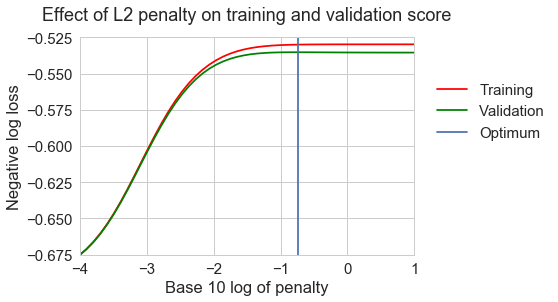

In [35]:
# plot the results
plt.plot(np.log10(L2_values), train_scores, 'r-', label='Training')
plt.plot(np.log10(L2_values), val_scores, 'g-', label='Validation')
plt.xlim((-4, 1))
plt.ylim((-0.675, -0.525))
plt.xlabel('Base 10 log of penalty')
plt.ylabel('Negative log loss')

# plot the optimum by looking at the maximum validation score
plt.axvline(x=np.log10(L2_values[np.argmax(val_scores)]), label='Optimum')
print('Optimum value of C is %.3f, which gives a validation score of %.3f' % (L2_values[np.argmax(val_scores)],max(val_scores)))

plt.title('Effect of L2 penalty on training and validation score', y=1.05)
plt.legend(loc=(1.05, 0.5))

We now have an optimum C value of 0.184. If C moves to the left in the graph above, the regularization effect gets stronger and the **bias** of the model increases, not allowing the model to fit the data well. If C moves to the right in the above graph, the regularization effect gets weaker and generally the **variance** of the model will increase as the model parameters become more specific to the data set used to train it. 

In our model, it seems that further increasing the C value does not hurt the average score. This is because the model has a fairly high bias to begin with (being a linear model with only a few features), so the reducing regularization has no further effect on the bias and therefore the variance also stays the same. Infact, the default C=1.0 value gave us the exact same scores.

In situations with more complex models and more features, the training and validation scores would diverge to the right hand side of the optimum and so the process followed would be much more important in that situation.

Let's take a look at the coefficients the model finds!

In [39]:
# First retrain the model with the correct C parameter on the entire training set:
logreg_model = LogisticRegression(C=0.184)
logreg_model.fit(X_train, Y_train)

# Let's look at the coefficients
feature_names = list(train_data)
coefficients = logreg_model.coef_

for i in range(len(coefficients[0])):
    print(feature_names[i]+ ': ' + str(round(coefficients[0][i],3)))
    
print('Intercept: ' + str(round(logreg_model.intercept_[0],3)))

SeedDiff: -0.954
OffEffDiff: 0.311
DefEffDiff: -0.512
AssistRatioDiff: -0.151
OffRebDiff: 0.23
OeFGDiff: 0.106
DeFGDiff: 0.187
TORateDiff: -0.126
Intercept: -0.024


We can see from this table the relative importance assigned to each of the features. As expected, the SeedDiff has by far the highest weighting. Significant weights are also assigned to the Offensive/Defensive Efficiency Difference and the Offensive Rebounding Difference.

Let's see how well we predict on the test data:

In [40]:
predictions = logreg_model.predict(X_test) # binary predictions
prediction_probs = logreg_model.predict_proba(X_test) # probabilities

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import log_loss

print('Accuracy: ' + str(round(accuracy_score(Y_test, predictions),3)) + '\n')
print('Classification report: \n')
print(classification_report(Y_test, predictions))
print('Confusion matrix: \n')
print(confusion_matrix(Y_test, predictions))

Accuracy: 0.684

Classification report: 

             precision    recall  f1-score   support

          0       0.67      0.68      0.67       188
          1       0.70      0.69      0.69       205

avg / total       0.68      0.68      0.68       393

Confusion matrix: 

[[128  60]
 [ 64 141]]


We can see that we get prediction accuracy of 0.684, an average F1 score of 0.68 between the 2 output classes, and the confusion matrix shows that the errors are roughly equally distributed between false positives and false negatives. This is a little bit disappointing because as we said at the start of the notebook just predicting based on the difference in seeds would get an accuracy of around 0.698. 

Let's also take a look at the log loss, as this is what the Kaggle Competition is actually scored on:

In [48]:
print(log_loss(Y_test, prediction_probs)) 

0.56930582214


The log loss on the test set of 0.569 is slightly worse than the value calculated during cross validation of 0.535. The difference is fairly small though and the model has generalized well to the previously unseen data.

**Log loss vs accuracy**

In a competition such as this, where many people will be making similar predictions, the pure accuracy of predictions is not descriptive enough to compare models. Log loss is useful because it gives a measure of **how confident** the model was when making predictions. For example, if the outcome was a win (1) but the prediction probability was only 0.55 then the model wasn't very confident in it's answer.

## 4. Competition Performance and Improvement Ideas <a class="anchor" id="fourth-bullet"></a>

My final submission for this competition followed this same approach however as 2 submissions were allowed I also created a decision tree model. The performances on the 2018 tournament were:

* Logistic Regression Model - Log loss = 0.624430
* Decision Tree Model - Log Loss = 0.612544

Which gave me a final position on the leaderboard of 458/934. For reference, the winning submission had a log loss of 0.531942. 

As this is my first real competition not relying on tutorials and other competitors kernels, I think it's worth spending some time to look at where my model fell short and how it could be improved.

1. **High Bias/Simple model** The linear model used here is very simple and unable to capture non-linear features that may have helped to make better predictions. A slight improvement was found when using decision trees, as these can use multiple linear segments to divide up the decision space, but ultimately a more flexible model was required.
2. **Important features missing** There were a number of other data files that I didn't use that had, for example, media outlet rankings of the teams, location of team home city, the names of the players and coaches. I could have also used external data such as how many players on the team are going to join the NBA next year, how old are the players on the team etc. Probably the biggest oversight of the model is that it does not have any indication of how difficult a teams matches have been in a particular season. The model compares statistics of different teams but a team that plays against mostly poor opponents will naturally have better statistics than a team that plays against mostly tough opposition. The statistics are compared directly when they perhaps shouldn't be.
3. **Assumptions of Logistic Regression** One of the major assumptions of Linear Regression is that there is little or no multi-colinearity in the data. The correlation matrix that was produced earlier showed that there were some very strong correlations between features and this could have impacted on the results.

**Potential improvements:** Gather more features, create features that are non-linear combinations of other features, choose another model (e.g. Neural Network, Ensemble method such as Random Forests), remove highly correlated features.

## Conclusions
* Sports predictions are difficult, due to the inherent random variability of player & team performance 'on the day'.
* I have a number of things to work on to try and create an improved model.
* The model still performed fairly well when compared with the rest of the competition submissions. Potentially because there were a number of upsets in this years tournament that will have punished anybody hard-coding for example a 1 seed vs 16 seed matchup. Until this year, a 16 seed had never won that matchup so many competitors will have artificially set this result to 1.0 probability.